# Generate X and y for CNN model

In [1]:
# run only once.
import os
os.chdir("..")
!pwd
!pyenv version
%load_ext autoreload
%autoreload 2

/Users/loicmorel/code/projetcs/crypto_assistant
crypto_assistant (set by PYENV_VERSION environment variable)


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyts.image import GramianAngularField
from mpl_toolkits.axes_grid1 import ImageGrid
from datetime import datetime
from datetime import timezone
from app.indicators import find_swings
from app.indicators import classify_swings

In [3]:
# run me...
def generate_gaf(data):
    gadf = GramianAngularField(method='difference', image_size=data.shape[0])
    img = gadf.fit_transform(pd.DataFrame(data).T)[0]
    return img

def generate_gaf_images_from_ohlc(data, params, idx):
    ## slicing data from the bottom of the df (reverse the time) 
    ## to the top from the index provided by the lambda function
    
    data_slice = data[:idx][['o_ts'] + encode_gaf_params['focus'] + encode_gaf_params['target']]
    img = []
    ret = params.copy()
    
    for t in params['target']:
        if data_slice.iloc[-1][t]:
            target = t
    ret['target'] = target
    
    ## for 4x frequency to compose the gaf matrix
    for freq in params['freq']:
        data_ = data_slice.groupby(pd.Grouper(key='o_ts', freq=freq)).mean().reset_index()
        data_ = data_.dropna()
        data__ = data_[::-1].reset_index().drop(columns='index')
        data___ = data__[:params['depth']]
        if data___.shape[0] < params['depth']:
            #print("data___.shape[0] < params['depth']:", data___.shape[0], params['depth'])
            return np.nan
        ret[f'start_time_{freq}'] = data___['o_ts'].iloc[0]
        ret[f'end_time_{freq}'] = data___['o_ts'].iloc[-1]
        img.append(generate_gaf(data___[params['focus']]))
    ret['img'] = np.array(img)
    return (ret)

def plot_gaf_image_matrix(img_np, target):
    image_matrix: tuple =(2, 2)
    fig = plt.figure(figsize=[img * 4 for img in image_matrix])
    plt.title(f'Target: {target}')
    grid = ImageGrid(fig,
                     111,
                     axes_pad=0,
                     nrows_ncols=image_matrix,
                     share_all=True,
                     )

    for ax, im in zip(grid, img_np):
        # Iterating over the grid returns the Axes.
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(im, cmap='rainbow', origin='lower')


# Data collection

In [5]:
from app.data_mgt.datamgt import ohlcv_from_csv_to_df
file = 'data/ohlcv_FTMUSDT_1h_from_1589122800000_to_1652245200000.csv'
data = ohlcv_from_csv_to_df(file)
data

,o_ts,Open,High,Low,Close,Volume,c_ts,o_date
0,2020-05-10 15:00:00,0.00355,0.00357,0.00350,0.00355,2615145.0,2020-05-10 15:59:59.999000064,18392.625000
1,2020-05-10 16:00:00,0.00356,0.00356,0.00333,0.00339,6861824.2,2020-05-10 16:59:59.999000064,18392.666667
2,2020-05-10 17:00:00,0.00337,0.00344,0.00336,0.00341,2626792.0,2020-05-10 17:59:59.999000064,18392.708333
3,2020-05-10 18:00:00,0.00344,0.00346,0.00340,0.00340,814335.1,2020-05-10 18:59:59.999000064,18392.750000
4,2020-05-10 19:00:00,0.00344,0.00351,0.00341,0.00346,2444376.8,2020-05-10 19:59:59.999000064,18392.791667
...,...,...,...,...,...,...,...,...
17509,2022-05-11 01:00:00,0.53560,0.53920,0.51800,0.51960,9436310.0,2022-05-11 01:59:59.999000064,19123.041667
17510,2022-05-11 02:00:00,0.51950,0.54240,0.51310,0.53940,10613461.0,2022-05-11 02:59:59.999000064,19123.083333
17511,2022-05-11 03:00:00,0.53960,0.54410,0.52040,0.52310,9633854.0,2022-05-11 03:59:59.999000064,19123.125000
17512,2022-05-11 04:00:00,0.52310,0.52930,0.50690,0.50800,14503294.0,2022-05-11 04:59:59.999000064,19123.166667


# Targets definition to the dataframe

In [31]:
def adding_target_to_data(data):
    # add HH, LL, LH, HL and NP targets to the dataframe
    target_df = classify_swings(find_swings(data))
    # concat databases
    data_c = pd.concat([data, target_df], axis="columns")
    data_c.drop(columns=[
        'c_ts',
        'CSLS',
        'Support',
        'Resistance',
        'Strong_lows',
        'Strong_highs',
        'FSL',
        'FSH',
        'Highs',
        'Lows',
        'Last',
        'Trend',
        'o_date'
        ], inplace=True)
    data_c[['HH','HL','LL','LH']] = data_c[['HH','HL','LL','LH']] * 1
    data_c['sum'] = data_c[['HH','HL','LL','LH']].sum(axis=1)
    data_c['NP'] = data_c['sum'].apply(lambda x: 1 if x==0 else 0)
    data_c.drop(columns='sum',inplace=True)
    return data_c

data_c = adding_target_to_data(data)
data_c=data_c[-1000:-1].reset_index().drop(columns='index')
data_c

,o_ts,Open,High,Low,Close,Volume,LL,HL,HH,LH,NP
0,2022-03-30 14:00:00,1.4044,1.4098,1.3904,1.4023,4199744.0,0,0,0,0,1
1,2022-03-30 15:00:00,1.4023,1.4100,1.3871,1.4099,4295361.0,0,0,0,0,1
2,2022-03-30 16:00:00,1.4099,1.4334,1.4047,1.4226,5075667.0,0,0,0,0,1
3,2022-03-30 17:00:00,1.4225,1.4540,1.4190,1.4512,6377230.0,0,1,0,0,0
4,2022-03-30 18:00:00,1.4512,1.4550,1.4261,1.4280,5369866.0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
994,2022-05-11 00:00:00,0.5333,0.5525,0.5306,0.5356,18851657.0,1,0,0,0,0
995,2022-05-11 01:00:00,0.5356,0.5392,0.5180,0.5196,9436310.0,0,0,0,0,1
996,2022-05-11 02:00:00,0.5195,0.5424,0.5131,0.5394,10613461.0,0,0,0,1,0
997,2022-05-11 03:00:00,0.5396,0.5441,0.5204,0.5231,9633854.0,0,0,0,0,1


# OHLC convertsion to GAF matrix

In [32]:
# generate img 2D array + params (freq, deepth) from dataframe and tag with target value

### ATTENTION: the freq[0] shall match with the freq of the raw data

encode_gaf_params = {
    # Depth of the timeframe, higher depth = bigger image.
    'depth': 40,
    # always 4x different frequency to constitute the 2x2 matrix of GAF images
    'freq': ['1h', '2h', '4h', '1d'],
    # focus on the Close price
    'focus': ['Close'],
    # sensitiive to targets LL and HH
    'target': ['LL','HL','HH','LH','NP']
}

In [33]:
data_c['gaf'] = data_c[::-1].apply(lambda r: generate_gaf_images_from_ohlc(data_c, encode_gaf_params, r.name+1), axis=1)
data_c = data_c.dropna().reset_index().drop(columns='index')
data_c

,o_ts,Open,High,Low,Close,Volume,LL,HL,HH,LH,NP,gaf
0,2022-05-08 00:00:00,0.6836,0.6889,0.6744,0.6767,3216599.0,0,0,0,0,1,"{'depth': 40, 'freq': ['1h', '2h', '4h', '1d']..."
1,2022-05-08 01:00:00,0.6768,0.6811,0.6685,0.6691,4305631.0,0,0,0,1,0,"{'depth': 40, 'freq': ['1h', '2h', '4h', '1d']..."
2,2022-05-08 02:00:00,0.6691,0.6733,0.6615,0.6731,9401137.0,0,0,0,0,1,"{'depth': 40, 'freq': ['1h', '2h', '4h', '1d']..."
3,2022-05-08 03:00:00,0.6732,0.6809,0.6655,0.6779,5378168.0,0,0,0,0,1,"{'depth': 40, 'freq': ['1h', '2h', '4h', '1d']..."
4,2022-05-08 04:00:00,0.6779,0.6862,0.6742,0.6745,3697477.0,1,0,0,0,0,"{'depth': 40, 'freq': ['1h', '2h', '4h', '1d']..."
...,...,...,...,...,...,...,...,...,...,...,...,...
72,2022-05-11 00:00:00,0.5333,0.5525,0.5306,0.5356,18851657.0,1,0,0,0,0,"{'depth': 40, 'freq': ['1h', '2h', '4h', '1d']..."
73,2022-05-11 01:00:00,0.5356,0.5392,0.5180,0.5196,9436310.0,0,0,0,0,1,"{'depth': 40, 'freq': ['1h', '2h', '4h', '1d']..."
74,2022-05-11 02:00:00,0.5195,0.5424,0.5131,0.5394,10613461.0,0,0,0,1,0,"{'depth': 40, 'freq': ['1h', '2h', '4h', '1d']..."
75,2022-05-11 03:00:00,0.5396,0.5441,0.5204,0.5231,9633854.0,0,0,0,0,1,"{'depth': 40, 'freq': ['1h', '2h', '4h', '1d']..."


In [9]:
row_nb = 900
generate_gaf_images_from_ohlc(data_c, encode_gaf_params, row_nb + 1)

nan

In [10]:
data_c.iloc[2].gaf['img']

array([[[ 0.        ,  0.69399424,  0.7097795 , ...,  0.85017829,
          0.        ,  0.66240124],
        [-0.69399424,  0.        ,  0.0221613 , ...,  0.97749626,
          0.69399424,  0.99682127],
        [-0.7097795 , -0.0221613 ,  0.        , ...,  0.97258121,
          0.7097795 ,  0.99834206],
        ...,
        [-0.85017829, -0.97749626, -0.97258121, ...,  0.        ,
          0.85017829,  0.28815955],
        [-0.        , -0.69399424, -0.7097795 , ..., -0.85017829,
          0.        , -0.66240124],
        [-0.66240124, -0.99682127, -0.99834206, ..., -0.28815955,
          0.66240124,  0.        ]],

       [[ 0.        ,  0.14281915,  0.44186206, ..., -0.60634564,
         -0.98358777, -0.6015196 ],
        [-0.14281915,  0.        ,  0.30921181, ..., -0.71369984,
         -0.99927372, -0.70944554],
        [-0.44186206, -0.30921181,  0.        , ..., -0.89531162,
         -0.96208519, -0.89259808],
        ...,
        [ 0.60634564,  0.71369984,  0.89531162, ...,  

In [11]:
data_c.iloc[2].gaf['target']

'NP'

# display GAF matrix as images

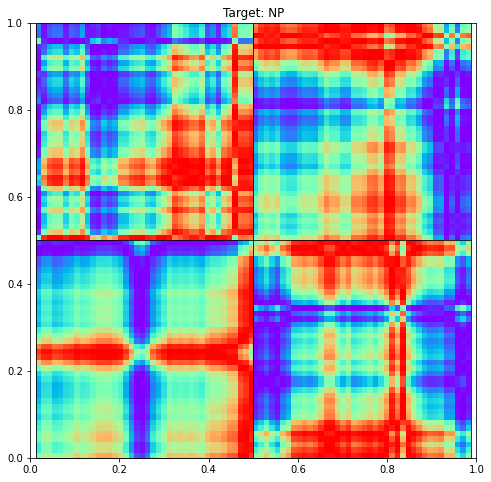

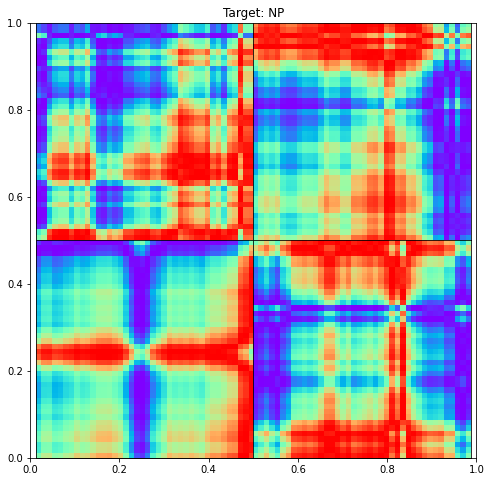

In [12]:
# print 2 last gaf images
for img in data_c[0:2].gaf:
    plot_gaf_image_matrix(img['img'], img['target'])

# Generate X and y

In [34]:
X = []
y = []

for gaf_meta in data_c.gaf:
    X.append(gaf_meta['img'])
X = np.array(X)
y = data_c[encode_gaf_params['target']]
y = np.array(y)

X.shape, y.shape

((77, 4, 40, 40), (77, 5))

In [14]:
from sklearn.metrics import confusion_matrix
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import utils
from tensorflow.keras import optimizers, metrics

In [15]:
def get_model(params):
    model = models.Sequential()

    # Conv1
    model.add(layers.Conv2D(16, (2, 2), input_shape=X.shape[1:], padding='same', strides=(1, 1)))
    model.add(layers.Activation('sigmoid'))

    # Conv2
    model.add(layers.Conv2D(16, (2, 2), padding='same', strides=(1, 1)))
    model.add(layers.Activation('sigmoid'))

    # FC
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.3))

    model.add(layers.Dense(y.shape[1],activation='softmax'))
    model.summary()

    return model

In [35]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [36]:
from tensorflow.keras.callbacks import EarlyStopping

es=EarlyStopping(monitor='accuracy', patience=20)

In [37]:
def train_model(params):
    model = get_model(params)
    model.compile(loss='categorical_crossentropy', optimizer=params['optimizer'], metrics=['accuracy'])
    hist = model.fit(x=X_train, y=y_train,
                     validation_split=0.2,
                     batch_size=params['batch_size'], epochs=params['epochs'], verbose=2,callbacks = [es])

    return (model, hist)

In [38]:
PARAMS = {}
PARAMS['model_name'] = './model/cnn_model_v1.h5'
PARAMS['classes'] = 5
PARAMS['lr'] = 0.01
PARAMS['epochs'] = 50
PARAMS['batch_size'] = 64
PARAMS['optimizer'] = optimizers.SGD(lr=PARAMS['lr'])

# ---------------------------------------------------------

# train cnn model
model, hist = train_model(PARAMS)
# model.save(PARAMS['model_name'])
    
model.evaluate(X_test,y_test)

/Users/loicmorel/.pyenv/versions/3.8.12/envs/crypto_assistant/lib/python3.8/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 4, 40, 16)         2576      
_________________________________________________________________
activation_2 (Activation)    (None, 4, 40, 16)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 40, 16)         1040      
_________________________________________________________________
activation_3 (Activation)    (None, 4, 40, 16)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2560)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               327808    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)              

[1.0257364511489868, 0.692307710647583]

## Prediction

In [39]:
def _idx_from_dt(data, dt):
    for index in range(0, len(data)):
        if (index+1) >= len(data) and data['o_ts'][index] >= dt:
            return index
        elif (index+1) >= len(data):
            return -1
        elif data['o_ts'][index] <= dt and data['o_ts'][index+1] > dt:
            return index
    return -1

In [47]:
data_p = ohlcv_from_csv_to_df(file)
data_p = data_p[-1000:-1].reset_index().drop(columns='index')

In [55]:
predict_date = datetime.strptime("2022-05-02_07:00:00", "%Y-%m-%d_%H:%M:%S")

In [49]:
data_p = adding_target_to_data(data_p)

In [56]:
ret = generate_gaf_images_from_ohlc(data_p, encode_gaf_params, _idx_from_dt(data, predict_date)+1)
ret

{'depth': 40,
 'freq': ['1h', '2h', '4h', '1d'],
 'focus': ['Close'],
 'target': 'NP',
 'start_time_1h': Timestamp('2022-05-11 04:00:00'),
 'end_time_1h': Timestamp('2022-05-09 13:00:00'),
 'start_time_2h': Timestamp('2022-05-11 04:00:00'),
 'end_time_2h': Timestamp('2022-05-07 22:00:00'),
 'start_time_4h': Timestamp('2022-05-11 04:00:00'),
 'end_time_4h': Timestamp('2022-05-04 16:00:00'),
 'start_time_1d': Timestamp('2022-05-11 00:00:00'),
 'end_time_1d': Timestamp('2022-04-02 00:00:00'),
 'img': array([[[ 0.00000000e+00,  6.67862693e-01,  8.83597485e-01, ...,
           5.64297454e-01,  4.62658020e-01,  0.00000000e+00],
         [-6.67862693e-01,  0.00000000e+00,  3.44923048e-01, ...,
           9.71366289e-01,  9.36434072e-01,  6.67862693e-01],
         [-8.83597485e-01, -3.44923048e-01,  0.00000000e+00, ...,
           9.93703674e-01,  9.99980060e-01,  8.83597485e-01],
         ...,
         [-5.64297454e-01, -9.71366289e-01, -9.93703674e-01, ...,
           0.00000000e+00,  1.1831

In [51]:
ret

{'depth': 40,
 'freq': ['1h', '2h', '4h', '1d'],
 'focus': ['Close'],
 'target': 'NP',
 'start_time_1h': Timestamp('2022-05-11 04:00:00'),
 'end_time_1h': Timestamp('2022-05-09 13:00:00'),
 'start_time_2h': Timestamp('2022-05-11 04:00:00'),
 'end_time_2h': Timestamp('2022-05-07 22:00:00'),
 'start_time_4h': Timestamp('2022-05-11 04:00:00'),
 'end_time_4h': Timestamp('2022-05-04 16:00:00'),
 'start_time_1d': Timestamp('2022-05-11 00:00:00'),
 'end_time_1d': Timestamp('2022-04-02 00:00:00'),
 'img': array([[[ 0.00000000e+00,  6.67862693e-01,  8.83597485e-01, ...,
           5.64297454e-01,  4.62658020e-01,  0.00000000e+00],
         [-6.67862693e-01,  0.00000000e+00,  3.44923048e-01, ...,
           9.71366289e-01,  9.36434072e-01,  6.67862693e-01],
         [-8.83597485e-01, -3.44923048e-01,  0.00000000e+00, ...,
           9.93703674e-01,  9.99980060e-01,  8.83597485e-01],
         ...,
         [-5.64297454e-01, -9.71366289e-01, -9.93703674e-01, ...,
           0.00000000e+00,  1.1831

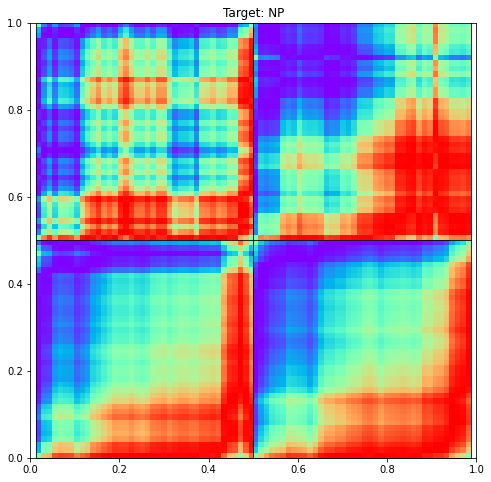

In [52]:
plot_gaf_image_matrix(ret['img'], ret['target'])

In [27]:
pred_proba = model.predict(np.array([ret['img']]))
pred_proba

array([[0.10954168, 0.12704279, 0.07298441, 0.08665659, 0.6037745 ]],
      dtype=float32)

In [28]:
pred = np.argmax(pred_proba)
encode_gaf_params['target'][pred]

'NP'